In [10]:
# Imports
# Basics
from __future__ import print_function, division
import pandas as pd
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import shutil
import glob
import os
import cv2
from scipy.misc import imread
# sklearn
from sklearn.metrics import f1_score, accuracy_score

import heapq
from pprint import pprint
import coremltools
from IPython.display import SVG

# keras
from keras.layers import Dense, Flatten, Embedding, Reshape, Activation, SimpleRNN, GRU, LSTM, GlobalAveragePooling1D,GlobalAveragePooling2D, Convolution1D,Convolution2D, MaxPooling1D,MaxPooling2D, Merge, Dropout
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.models import Sequential, Model
from keras.models import load_model
from keras.layers import Dense
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.utils.visualize_util import model_to_dot, plot
from keras.datasets import imdb, reuters
from keras.preprocessing import sequence, image
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Nadam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import decode_predictions, preprocess_input, _obtain_input_shape

# logging (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [1]:
def image_array(file_path):
    '''Turn image into an array
    INPUT: Filepath
    OUTPUT: Numpy array'''
    image = cv2.imread(file_path)
    return np.array(image)

def plot_image(file_path):
    '''Plot an image
    INPUT: Filepath
    OUTPUT: Image plot'''
    image = cv2.imread(file_path)
    return plt.imshow(image)

#### Open data frame only with car models appearing more than 10 times (> 30 pictures per class).

In [ ]:
df_10 = pd.read_csv('grouped10.csv')
df_10.head()

In [ ]:
# Class labels
df_10['merged'] = df_10['Make']+'_'+df_10['Model']
models = df_10.merged

In [ ]:
classes_countunder30 = df_10.sort_values('Count',ascending=True)[:200].merged

#### Put file paths and corresponding labels in a data frame.  

In [ ]:
car_models = {}
for model in df_10.merged:
    car_models[model] = 1

### Folder set up

Car models called 'Other' were deleted  
Delete all car models with less than 11 cars / 30 pictures  
Input: 'AD/AutoDetect/'  

In [ ]:
def delete_underpopulated_car(folder):
    '''
    INPUT: Folder path
    Function to delete folders of car models with under 30 images. 
    '''
    for filename in glob.iglob(folder+'*.jpg'):
        car_model = '_'.join([filename.split('_')[1],filename.split('_')[2]])
        if car_model not in car_models:
            os.remove(filename)

Create test set folders with 10  
size of test/validation set: number_samples  
Image folder: 'AD/AutoDetect/'  
Test/validation folder: 'AD/validation/'  

In [2]:
def test_set_folders(image_folder,test_folder,number_samples):
    '''Set up folders of validation set by moving images from training set
    INPUT: Folder with images, validation set folder, Number of samples
    '''
    #number_samples = 2633
    count = 0
    for filename in glob.iglob(image_folder+'*.jpg'):
        model = '_'.join([filename.split('_')[1],filename.split('_')[2]])
        model2 = '_'.join([filename.split('/')[2]])

        if os.path.exists(test_folder+str(model)):
            shutil.move(filename, test_folder+str(model)+'/'+str(model2))
            count += 1
            #pass
        else:
            os.makedirs(test_folder+str(model))
            shutil.move(filename, test_folder+str(model)+'/'+str(model2))

        if count == number_samples:
            break

Create train set folders  
Image folder: 'AD/AutoDetect/'

In [3]:
def train_set_folders(folder):    
    '''Set up folders of training set
    INPUT: Folder path
    OUTPUT: Folders with car model names 'Audi_S6'
    '''    
    for filename in glob.iglob(folder+'*.jpg'):
        model = '_'.join([filename.split('_')[1],filename.split('_')[2]])
        model2 = '_'.join([filename.split('/')[2]])

        if os.path.exists(folder+str(model)):
            shutil.move(filename, folder+str(model)+'/'+str(model2))
        else:
            os.makedirs(folder+str(model))
            shutil.move(filename, folder+str(model)+'/'+str(model2))

In [4]:
def get_class_labels():
    '''Get all class labels / car models'''
    labels = []
    image_files = []
    for filename in glob.iglob('AD/AutoDetect/*.jpg'):
        model = '_'.join([filename.split('_')[1],filename.split('_')[2]])
        if model in set(models):
            image_files.append(filename)
            labels.append(model)
    return labels, image_files

All folders / car models which had to be renamed to combine all of them.  
Example: Audi TT, Audi TT 2.0, Audi TT TDI

In [ ]:
cars = ['Audi_A3','Audi_A4','Audi_A6','Audi_A8','Audi_Q5','Audi_R8','Audi_RS6','Audi_S4','Audi_S6','Audi_TT','Bentley_Continental','Bentley_Flying','BMW_3','BMW_6','BMW_M3','BMW_M4',\
        'BMW_M5','BMW_X1','BMW_X3','BMW_X5','BMW_Z4','Buick_Electra','Buick_Regal','Buick_Lucerne','Buick_GS',\
        'Buick_Special','Buick_Super','Cadillac_60','Cadillac_CTS','Cadillac_Coupe','Cadillac_DeVille','Cadillac_Deville',\
        'Cadillac_Eldorado','Cadillac_DTS','Cadillac_Escalade','Cadillac_Fleetwood','Cadillac_SRX','Cadillac_XTS',\
        'Chevrolet_5','Chevrolet_210','Chevrolet_Corvette','Chevrolet_Deluxe','Chevrolet_Monte','Chevrolet_Nova',\
        'Chrysler_200','Chrysler_300','Chrysler_Pacifica','Chrysler_PT','Chrysler_Sebring','Chrysler_Town',\
         'Edsel_Ranger','Excalibur_Phaeton','Ferrari_250','Ferrari_355','Ferrari_360','Ferrari_458','Ferrari_488',\
        'Ferrari_550','Ferrari_599','Ferrari_612','Ferarri_California','Ferrari_F12','Fiat_124','Fiat_600','Fiat Spider',\
        'Ford_Custom','Ford_E-Series','Ford_Deluxe','Ford_Explorer','Ford_Roadster','Ford_Super','Ford_Transit',\
         'FREIGHTLINER_M2-112','Freightliner_Sprinter','Genesis_G90','GMC_C4500','GMC_1000','GMC_Savana','GMC_Sierra',\
         'GMC_Yukon','Honda_Accord','Honda_Odyssey','Honda_Pilot','Honda_Ridgeline','Hudson_Hornet','Hudson_Super',\
        'Hyundai_Elantra','Hummer_H1','Hummer_H2','Hummer_H3','Hyundai_Sonata','Hyundai_Veloster','Infiniti_G37',\
         'Infiniti_Q50','Infiniti_QX80','INTERNATIONAL_4300','Isuzu_NPR','Jaguar_XF','Jaguar_XJ','Jeep_Cherokee',\
         'Jeep_Compass','Jeep_J10','Jeep_Pickup','Jeep_Wrangler','Kia_Optima','Kia_Rio','Lamborghini_Aventador',\
        'Lamborghini_Countach','Lamborghini_Diablo','Lamborghini_Gallardo','Lamborghini_Hurracan','Lamborghini_Murcielago',\
         'Lamborghini_Urraco','Land\ Rover_Range Rover','Lexus_GS','Lexus_ES','Lexus_GX','Lexus_HS','Lexus_IS','Lexus_LS',\
        'Lexus_LX','Lexus_RC','Lexus_RX','Lexus_SC','Lincoln_Continental','Lincoln_MKC','Lincoln_Town','Lincoln_Zephyr',\
        'Maserati_Ghibli','Maserati_Quattroporte','Maybaych_57','Mazda_CX-9','Mercedes-Benz_280','Mercedes-Benz_300',\
        'Mercedes-Benz_C','Mercedes-Benz_CLS63','Mercedes-Benz_E','Mercedes-Benz_GLA','Mercedes-Benz_GLE','Mercedes-Benz_GLK',\
        'Mercedes-Benz_Metris','Mercedes-Benz_Replica','Mercedes-Benz_SLS','Mercedes-Benz_Sprinter','Mercury_convertible',\
        'Mercury_Eight','Mercury_Grand Marquis','Mini_Cooper','Mitsubishi_Eclipse','Mitsubishi_Galant','Mitsubishi_Outlander',\
        'Morris_Minor','Nash_Metropolitan','Nissan_Skyline','Oldsmobile_Cutlass','Oldsmobile_Jetstar','Packard_Clipper',\
        'Packard_Series','Plymouth_Belvedere','Plymouth_GTX','Plymouth_Special','Pontiac_Bonneville','Pontiac_Firebird',\
        'Pontiac_Montana','Pontiac_Safari','Pontiac_Solstice','Pontiac_Ventura','Porsche_356','Porsche_550','Porsche_911 GT3',\
        'Porsche_911 Turbo','Porsche_911 Carrera','Porsche_944','Porsche_964','Porsche_Boxster','Porsche_Cayman','Porsche_Carrera',\
        'Porsche_Cayenne','Porsche_Panamera','Ram_1500','Ram_2500','Ram_3500','Ram_4500','Ram_Ram','Renault_4','Rolls-Royce_Corniche',\
        'Rolls-Royce_Phantom','Rolls-Royce_Silver','Rolls-Royce_SILVER','Rolls-Royce_Wraith','Saab_9-5','Shelby_AC','Shelby_Cobra',\
        'Shelby_CSX','Studebaker_Champion','Studebaker_Commander','Subaru_Impreza','Subaru_WRX','Sunbeam_Alpine',\
        'Toyota_4Runner','Toyota_Avalon','Toyota_Corolla','Toyota_FJ40','Toyota_Crown','Toyota_MR2','Toyota_Pickup',\
        'Toyota_Prius','Toyota_RAV4','Toyota_Tacoma','Toyota_Tundra','Toyota_Supra','Toyota_Sienna','Triumph_GT6',\
        'Volkswagen_Golf','Volkswagen_Jetta','Volkswagen_Karmann','Volkswagen_Routan','Volvo_C70','Volvo_S60',\
        'Volvo_V60','Willys_CJ2A','Willys_Jeep']

## Building the model with only a few number of images before scaling up.
#### Create two data sets - train and test.

In [5]:
def train_test_dfs(num_images):
    '''Create train and test data frames.
    INPUT: Number of images
    OUTPUT: Two data frames
    '''
    train_split = 0.75*num_images
    test_split = 0.25*num_images
    
    train = pd.DataFrame([image_files[:train_split],labels[:train_split]]).transpose()
    test = pd.DataFrame([image_files[train_split:test_split],labels[train_split:test_split]]).transpose()
    
    return train, test

In [ ]:
train_df, test_df = train_test_dfs(5000)

### Create image arrays for both sets and resize images to the same size.

In [6]:
def create_img_array(df):
    '''
    INPUT: Data frame
    OUTPUT: image array with training data
    '''
    img_train = []
    for img_name in df[0]:
        img = image.load_img(img_name, target_size=(224,224))
        '''image array -> (3,155,155)'''
        img = image.img_to_array(img)
        img_train.append(img)
    #expand by 1 dimension to -> (1,3,155,155)
    #np.expand_dims(img, axis=0)
    img_train = np.array(img_train)
    #preprocess image by subtracting the mean RGB pixel intensity from the ImageNet dataset'''
    img_train = preprocess_input(img_train)
    img_train = np.array(img_train)
    
    return img_train

In [ ]:
img_train = create_img_array(train_df)

In [ ]:
#train_x = np.stack(img_train)

In [ ]:
#test_x = np.stack(temp2)

#### Change class labels into numeric values.

In [ ]:
def numerize_labels(num_classes):
    '''Create class labels'''
    classes = [i for i in range(1,(num_classes+1))]
    map_labels = dict(zip(train[1].unique(),classes))
    train_y = []
    for i in train[1].values:
        train_y.append(map_labels[i])
    return train_y

In [ ]:
train_y = numerize_labels(468)

In [ ]:
train_y = np.array(train_y)

#### Create a validation set out of the training set.

In [ ]:
split_size = int(img_train.shape[0]*0.8)
train_x, val_x = img_train[:split_size], img_train[split_size:]
train_y, val_y = train_y[:split_size], train_y[split_size:]

In [ ]:
train_x.shape,val_x.shape,val_x.shape,len(train_y),len(val_y)

In [ ]:
model.fit(train_x, train_y,batch_size=64,nb_epoch=10,shuffle=True,verbose=1,validation_data=(val_x, val_y))

# Make predictions
predictions_valid = model.predict(val_x, batch_size=64, verbose=1)
predictions_valid

### Modelling with a generator to scale up and use all 170k images (468 classes/car models).
### Best accuracy: 90% on training set and 80% on validation set.
#### Usage of the pre-trained model InceptionV3 as a base model and then train it with our data.

Create the pre-trained model.

In [13]:
base_model = InceptionV3(weights='imagenet', include_top=False)#, input_shape=(224,224,3))

#### Add additional layers and create generator that reads images directly from folders.

Setup:
- created a folder AD/
- created AutoDetect/ (train) and validation/ subfolders inside AD/
- created classes/car models subfolders inside AutoDetect/ and validation/
- Split: 130000 in train/AutoDetect and 30000 in validation

In [ ]:
x = base_model.output

# Global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# Fully-connected layer
x = Dense(468, activation='relu')(x)

# Removed Dropout layer and replaced it with a batch normalization layer since model was underfitting
#x = Dropout(0.2)(x)
x = BatchNormalization()(x)

# Logistic layer
predictions = Dense(468, activation='softmax')(x)

model = Model(base_model.input,predictions)

# Train only the top layers (randomly selected)
# -> freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model after freezing layers
adam = Adam(lr=0.0001, beta_1=0.9)
rms = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the image data
#model.fit(train_x, train_y, nb_epoch=10, batch_size=128, validation_data=(val_x, val_y))
batch_size = 64
epochs = 100
img_height = 224
img_width = 224
train_samples = 127647
val_samples = 27865

# Image Augmentation: rescale, zoom, zca whitening, horizontal flip
train_datagen = ImageDataGenerator(featurewise_center=True,
        rescale=1./255,
        #shear_range=0.2,
        zoom_range=0.2,
        zca_whitening=True,
        #rotation_range=0.5,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Process images directly from the folder using generators
train_generator = train_datagen.flow_from_directory(
        'AD/AutoDetect/',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'AD/validation/',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

# Fine-tune the model
print('First fitting:')
model.fit_generator(
        train_generator,
        samples_per_epoch=train_samples // batch_size,
        nb_epoch=epochs,
        validation_data=validation_generator,
        nb_val_samples=val_samples // batch_size)

# Now, the top layers are well trained and we can start fine-tuning convolutional layers from inception V3.
# -> freeze bottom layers and train the rest of the layers.

# Look at all layers to determine how many layers we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

# we will freeze the first 158 layers and unfreeze/train the rest:
# 28,44,60,70,92,114,136,158,172,191

for layer in model.layers[:158]:
    layer.trainable = False
for layer in model.layers[158:]:
    layer.trainable = True

Found 127647 images belonging to 468 classes.
Found 27864 images belonging to 468 classes.
First fitting:
Epoch 1/100
2048/1994 [==============================] - 47s - loss: 6.5503 - acc: 0.0015 - val_loss: 6.4458 - val_acc: 0.0045
Epoch 2/100
2048/1994 [==============================] - 44s - loss: 6.4694 - acc: 0.0039 - val_loss: 6.3504 - val_acc: 0.0045
Epoch 3/100
2048/1994 [==============================] - 43s - loss: 6.3394 - acc: 0.0117 - val_loss: 6.2329 - val_acc: 0.0201
Epoch 4/100
2048/1994 [==============================] - 44s - loss: 6.2947 - acc: 0.0166 - val_loss: 6.2396 - val_acc: 0.0223
Epoch 5/100
2048/1994 [==============================] - 43s - loss: 6.2384 - acc: 0.0249 - val_loss: 6.1703 - val_acc: 0.0268
Epoch 6/100
2048/1994 [==============================] - 43s - loss: 6.1987 - acc: 0.0210 - val_loss: 6.0390 - val_acc: 0.0379
Epoch 7/100
2048/1994 [==============================] - 44s - loss: 6.0653 - acc: 0.0303 - val_loss: 5.9226 - val_acc: 0.0379
Epoch

In [ ]:
print('Second fitting:')

# Recompile the model before training it again.
model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

# fine-tune the model
final_model = model.fit_generator(
        train_generator,
        samples_per_epoch=train_samples // batch_size,
        nb_epoch=epochs,
        validation_data=validation_generator,
        nb_val_samples=val_samples // batch_size)


In [ ]:
def scores_report(final_model):
    '''Function to return model accuracy & loss
    INPUT: model
    OUTPUT: epoch history'''
    
    history = final_model.history
    print('Highest accuracy{:.2%}'.format(max(history['acc'].values())*100))
    print('Lowest loss'+min(history['loss'].values()))
    print('Highest validation accuracy{:.2%}'.format(max(history['val_acc'].values())*100))
    print('Lowest validation loss'+min(history['val_loss'].values()))
    
    return history

In [ ]:
model.summary()

In [ ]:
scores_report(model)

### Predictions

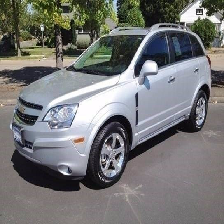

In [235]:
image.load_img('test3.jpg', target_size=(224,224))

In [7]:
def predict_img(filepath):
    '''Function to predict car model for single image.
    INPUT: File path
    OUTPUT: Five car models with highest probabilities
    '''
    # preprocess image
    img = image.load_img(filepath, target_size=(224,224))
    
    # image array -> (3,155,155)
    img = image.img_to_array(img)/255
    
    # expand by 1 dimension to -> (1,3,155,155)
    img = np.expand_dims(img, axis=0)
    
    x = model.predict(img)[0]
    
    return predict_top5(x,all_classes)

def predict_top5(pred_array, all_classes):
    '''Print out the five car models with highest probabilities
    INPUT: Array with predicted probabilities / output from model.predict()
    OUTPUT: Zipped list with car model name and probability
    '''
    # Take index of five highest values
    top5 = heapq.nlargest(5, enumerate(pred_array), key=lambda x: x[1])
    
    names = [all_classes[model[0]] for model in top5]
    zipped = list(zip(names, top5))

    return zipped


#folder: 'AD/AutoDetect/*'
def get_all_classes(folder_path):
    '''Get all car model names in a folder.'''
    all_models = []
    
    for filename in glob.iglob(folder_path):
        all_models.append(filename.split('/')[2])
        
    return dict(zip(list(range(468)),sorted(all_models)))

#### Predict with a generator.

In [224]:
all_classes = get_all_classes('AD/AutoDetect/*')

In [ ]:
gen = ImageDataGenerator(rescale=1./255).flow_from_directory('test_images/',
        target_size=(img_height, img_width),
        #batch_size=batch_size,
        class_mode='categorical',shuffle=False)
preds = model.predict_generator(gen, len(gen.filenames))

In [ ]:
for i in range(len(preds)):
    pprint(predict_top5(preds[i],all_classes))

In [27]:
predict_img('jag_xj.jpg')

[('Jaguar_XJ', (232, 0.64862746)),
 ('Jaguar_XJR', (234, 0.059021827)),
 ('BMW_6-Series', (24, 0.044623341)),
 ('Infiniti_Q60', (221, 0.033171169)),
 ('Infiniti_G37', (217, 0.025852574))]

### Test predictions on random car images from Google images.

In [56]:
test_set = ['test_images/Chevrolet_Spark/chev_spark.jpeg','test_images/BMW_5-Series/bmw_5.jpg',\
           'test_images/Audi_S6/Audis6.jpg','test_images/Ferrari_California/test6.jpg',\
            'test_images/Ford_Flex/fordcoupe.jpg','test_images/Jeep_Wrangler/Jeep_wrangler1.jpg',\
            'test_images/test5.jpg', 'test_images/test1.jpg','test_images/test4.jpg']

In [57]:
for i in test_set:
    print(i.split('/')[1])
    pprint(predict_img(i))

Chevrolet_Spark
[('Chevrolet_Spark', (102, 0.98404789)),
 ('Ford_Fiesta', (169, 0.0045500197)),
 ('Hyundai_Accent', (207, 0.0033944729)),
 ('Honda_Fit', (198, 0.0028861202)),
 ('Toyota_Matrix', (433, 0.0013247475))]
BMW_5-Series
[('BMW_5-Series', (23, 0.63634896)),
 ('BMW_7-Series', (25, 0.35353664)),
 ('Rolls-Royce_Ghost', (404, 0.0016020428)),
 ('BMW_X5', (34, 0.00150186)),
 ('BMW_2-Series', (19, 0.0011010148))]
Audi_S6
[('Audi_A6', (3, 0.499273)),
 ('Audi_S3', (12, 0.31383553)),
 ('Audi_S4', (13, 0.085752383)),
 ('Audi_RS4', (10, 0.028720986)),
 ('Audi_S6', (15, 0.027203791))]
Ferrari_California
[('Ferrari_California', (146, 0.92036408)),
 ('Fisker_Karma', (150, 0.042004593)),
 ('Maserati_Gran Turismo', (294, 0.01026198)),
 ('Lotus_Evora', (289, 0.0042934767)),
 ('Jaguar_F-Type', (228, 0.0037164725))]
Ford_Flex
[('Chrysler_PT Cruiser', (114, 0.35224703)),
 ('Chevrolet_HHR', (89, 0.2901603)),
 ('Chevrolet_Spark', (102, 0.05344915)),
 ('Volkswagen_Beetle - Classic', (447, 0.050430838)

### Visualize neural net architecture.

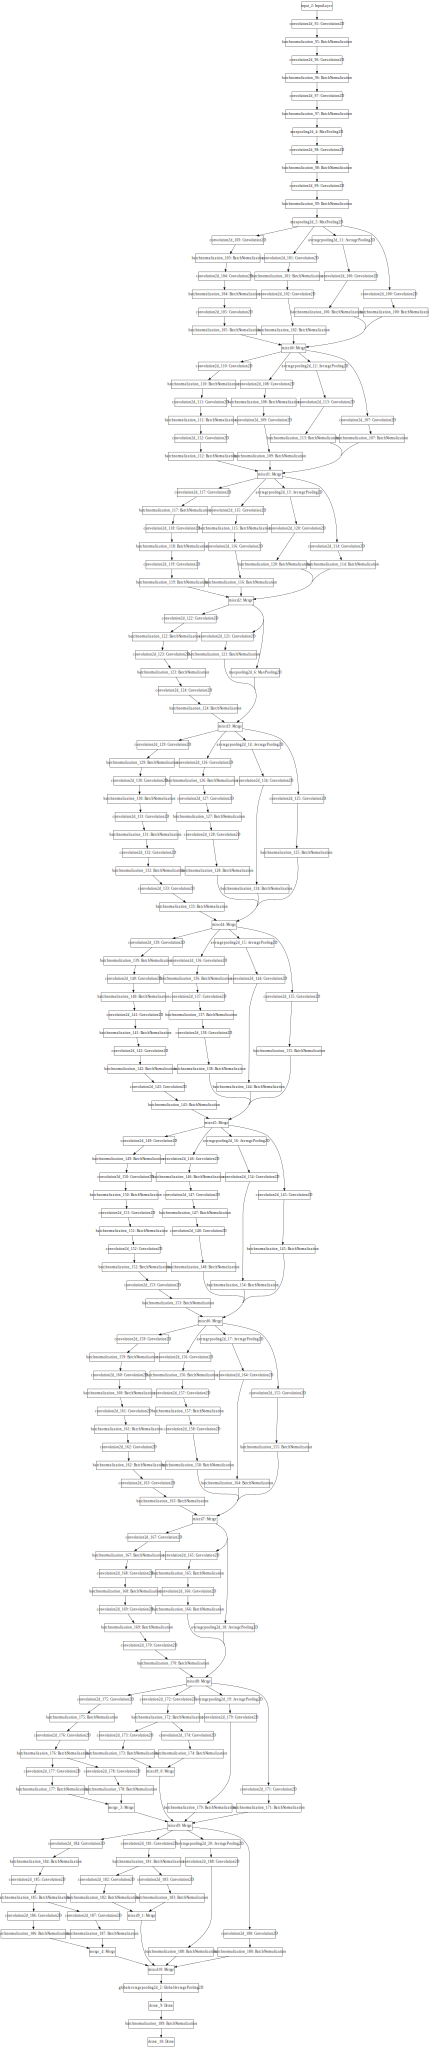

In [270]:
from keras.utils.visualize_util import plot, model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))#,'model.png')

### CoreML
#### Convert the keras into a CoreML model to use it in Xcode for iOS development.

In [136]:
scale = 1./255

In [137]:
coreml_model = coremltools.converters.keras.convert(model,
                                                    input_names='image',
                                                    #output_names=['probs'],
                                                    image_input_names='image',
                                                    class_labels='classes.txt',
                                                    predicted_feature_name='class',
                                                    image_scale=scale)

# Save Core ML Model
coreml_model.author = 'FP'
coreml_model.save("autodetect_v3.mlmodel")

0 : input_1, <keras.engine.topology.InputLayer object at 0x7f0f15e44110>
1 : convolution2d_1, <keras.layers.convolutional.Convolution2D object at 0x7f0f15e44690>
2 : convolution2d_1__activation__, <keras.layers.core.Activation object at 0x7f0df4a77f50>
3 : batchnormalization_1, <keras.layers.normalization.BatchNormalization object at 0x7f0f16698750>
4 : convolution2d_2, <keras.layers.convolutional.Convolution2D object at 0x7f0eb0004f50>
5 : convolution2d_2__activation__, <keras.layers.core.Activation object at 0x7f0dedead150>
6 : batchnormalization_2, <keras.layers.normalization.BatchNormalization object at 0x7f0eaff02b50>
7 : convolution2d_3, <keras.layers.convolutional.Convolution2D object at 0x7f0eafeda050>
8 : convolution2d_3__activation__, <keras.layers.core.Activation object at 0x7f0df4a24b50>
9 : batchnormalization_3, <keras.layers.normalization.BatchNormalization object at 0x7f0eafe17e50>
10 : maxpooling2d_1, <keras.layers.pooling.MaxPooling2D object at 0x7f0eafd3de90>
11 : con

91 : convolution2d_29__activation__, <keras.layers.core.Activation object at 0x7f0df4a22610>
92 : batchnormalization_29, <keras.layers.normalization.BatchNormalization object at 0x7f0eae0c6f90>
93 : convolution2d_27, <keras.layers.convolutional.Convolution2D object at 0x7f0eafb41350>
94 : convolution2d_27__activation__, <keras.layers.core.Activation object at 0x7f0df4a227d0>
95 : convolution2d_30, <keras.layers.convolutional.Convolution2D object at 0x7f0eae05fb10>
96 : convolution2d_30__activation__, <keras.layers.core.Activation object at 0x7f0df4c20c50>
97 : batchnormalization_27, <keras.layers.normalization.BatchNormalization object at 0x7f0eae30ad50>
98 : batchnormalization_30, <keras.layers.normalization.BatchNormalization object at 0x7f0eae011410>
99 : maxpooling2d_3, <keras.layers.pooling.MaxPooling2D object at 0x7f0eadf35510>
100 : mixed3, <keras.engine.topology.Merge object at 0x7f0eadee8310>
101 : convolution2d_35, <keras.layers.convolutional.Convolution2D object at 0x7f0eada

178 : convolution2d_53__activation__, <keras.layers.core.Activation object at 0x7f0deedabb90>
179 : convolution2d_58, <keras.layers.convolutional.Convolution2D object at 0x7f0eac163990>
180 : convolution2d_58__activation__, <keras.layers.core.Activation object at 0x7f0deedabd10>
181 : batchnormalization_53, <keras.layers.normalization.BatchNormalization object at 0x7f0eac602e90>
182 : batchnormalization_58, <keras.layers.normalization.BatchNormalization object at 0x7f0eac0d5710>
183 : averagepooling2d_6, <keras.layers.pooling.AveragePooling2D object at 0x7f0eabf21e50>
184 : convolution2d_51, <keras.layers.convolutional.Convolution2D object at 0x7f0eac893990>
185 : convolution2d_51__activation__, <keras.layers.core.Activation object at 0x7f0deedab650>
186 : convolution2d_54, <keras.layers.convolutional.Convolution2D object at 0x7f0eac558dd0>
187 : convolution2d_54__activation__, <keras.layers.core.Activation object at 0x7f0deedabb50>
188 : convolution2d_59, <keras.layers.convolutional.C

265 : convolution2d_84__activation__, <keras.layers.core.Activation object at 0x7f0deedabc50>
266 : averagepooling2d_9, <keras.layers.pooling.AveragePooling2D object at 0x7f0eaa311b10>
267 : convolution2d_77, <keras.layers.convolutional.Convolution2D object at 0x7f0eaac271d0>
268 : convolution2d_77__activation__, <keras.layers.core.Activation object at 0x7f0deedab890>
269 : batchnormalization_79, <keras.layers.normalization.BatchNormalization object at 0x7f0eaa8d4e50>
270 : batchnormalization_80, <keras.layers.normalization.BatchNormalization object at 0x7f0eaa7fde90>
271 : batchnormalization_83, <keras.layers.normalization.BatchNormalization object at 0x7f0eaa4419d0>
272 : batchnormalization_84, <keras.layers.normalization.BatchNormalization object at 0x7f0eaa366790>
273 : convolution2d_85, <keras.layers.convolutional.Convolution2D object at 0x7f0eaa260710>
274 : convolution2d_85__activation__, <keras.layers.core.Activation object at 0x7f0deedab110>
275 : batchnormalization_77, <keras

In [138]:
coreml_model

input {
  name: "image"
  type {
    imageType {
      width: 224
      height: 224
      colorSpace: RGB
    }
  }
}
output {
  name: "output1"
  type {
    dictionaryType {
      stringKeyType {
      }
    }
  }
}
output {
  name: "class"
  type {
    stringType {
    }
  }
}
predictedFeatureName: "class"
predictedProbabilitiesName: "output1"
metadata {
  author: "FP"
}

In [234]:
#m.predict(predict_img('test_images/test4.jpg'))
def get_predictions_one_img_per_class():
    '''OUTPUT: predictions for one 3 images per car model'''
    predictions = []
    f = []
    for i in glob.iglob('AD/train_bottleneck/*'):
        f.append(i)
    for j in f:
        #img = image.load_img(list(glob.iglob(j+'/*'))[0], target_size=(224,224))
        img1 = image.load_img(list(glob.iglob(j+'/*'))[0], target_size=(224,224))
        img2 = image.load_img(list(glob.iglob(j+'/*'))[0], target_size=(224,224))
        img3 = image.load_img(list(glob.iglob(j+'/*'))[0], target_size=(224,224))

        # image array -> (3,155,155)
        #img = image.img_to_array(img)/255
        img1 = image.img_to_array(img1)/255
        img2 = image.img_to_array(img2)/255
        img3 = image.img_to_array(img3)/255

        # expand by 1 dimension to -> (1,3,155,155)
        #img = np.expand_dims(img, axis=0)
        img1 = np.expand_dims(img1, axis=0)
        img2 = np.expand_dims(img2, axis=0)
        img3 = np.expand_dims(img3, axis=0)

        #x = m.predict(img)
        x1 = m.predict(img1)[0]
        x2 = m.predict(img2)[0]
        x3 = m.predict(img3)[0]
        #predictions.append(x)
        predictions.append(x1)
        predictions.append(x2)
        predictions.append(x3)
    return predictions

In [183]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarities(preds):
    '''
    INPUT: Predictions
    OUTPUT: Cosine similarities
    '''
    preds = [i[0] for i in preds]
    
    return cosine_similarity(preds)

cs = cosine_similarities(predictions)
cs

array([[ 0.99999982,  0.10085613, -0.06210266, ..., -0.07814679,
        -0.06297778,  0.01459757],
       [ 0.10085613,  0.99999988,  0.07933356, ...,  0.00840297,
         0.3043901 ,  0.07832944],
       [-0.06210266,  0.07933356,  1.        , ..., -0.12419236,
         0.01293819,  0.11807769],
       ..., 
       [-0.07814679,  0.00840297, -0.12419236, ...,  1.00000012,
        -0.03347645, -0.04648396],
       [-0.06297778,  0.3043901 ,  0.01293819, ..., -0.03347645,
         1.00000036,  0.10327784],
       [ 0.01459757,  0.07832944,  0.11807769, ..., -0.04648396,
         0.10327784,  1.00000012]], dtype=float32)

### T-SNE visualization

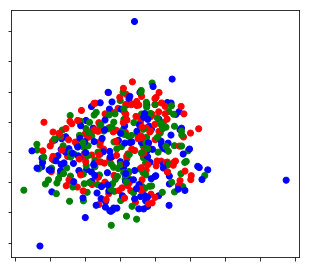

In [258]:
from sklearn.manifold import TSNE
from matplotlib.ticker import NullFormatter

tsne = TSNE(n_components=3,init='pca')
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(cs)
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=['r','g','b'])#, cmap=plt.cm.Spectral)
#plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

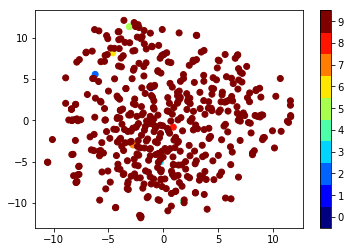

In [259]:
import numpy as np
from tsne import bh_sne

# load up data
x_data = predictions
y_data = all_classes.keys()

# convert image data to float64 matrix. float64 is need for bh_sne
x_data = np.asarray(x_data).astype('float64')
x_data = x_data.reshape((x_data.shape[0], -1))

# For speed of computation, only run on a subset
n = 1406
x_data = x_data[:n]
y_data = y_data[:n]

# perform t-SNE embedding
vis_data = bh_sne(x_data)

# plot the result
vis_x = vis_data[:, 0]
vis_y = vis_data[:, 1]

plt.scatter(vis_x, vis_y, c=y_data, cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

### Create new model and train it without last layer to calculate distances between images.


In [57]:
def new_model(original_model):
    inp = original_model.input
    output = original_model.layers[-2].output
    model = Model(inp,output)
    batch_size = 20
    datagen = ImageDataGenerator(rescale=1. / 255)
    generator = datagen.flow_from_directory(
            'AD/train_bottleneck',
            target_size=(224, 224),
            batch_size=batch_size,
            class_mode=None,
            shuffle=False)

    # a generator that yields batches of numpy data
    bottleneck_features_train = model.predict_generator(generator, 1404)
    # save the output as a Numpy array
    np.save('bottleneck_features_train.npy', bottleneck_features_train)

    generator = datagen.flow_from_directory(
            'AD/val_bottleneck',
            target_size=(224, 224),
            batch_size=batch_size,
            class_mode=None,
            shuffle=False)
    
    bottleneck_features_validation = model.predict_generator(generator, 918)
    np.save('bottleneck_features_validation.npy', bottleneck_features_validation)

In [59]:
new_model(model)

Found 1404 images belonging to 468 classes.
Found 918 images belonging to 307 classes.


In [ ]:
t = np.load('/home/ubuntu/bottleneck_features_validation.npy')

In [60]:
def folder_structure_train_bottleneck():
    for foldername in glob.iglob('AD/AutoDetect/*'):
        folder = 'AD/train_bottleneck/'+foldername.split('/')[2]
        os.mkdir(folder)
        img1 = list(glob.iglob(foldername+'/*'))[0]
        img2 = list(glob.iglob(foldername+'/*'))[1]
        img3 = list(glob.iglob(foldername+'/*'))[2]
        shutil.copy2(img1, folder)
        shutil.copy2(img2, folder)
        shutil.copy2(img3, folder)
        print(foldername)

In [61]:
def folder_structure_val_bottleneck():
    for foldername in glob.iglob('AD/validation/*'):
        folder = 'AD/val_bottleneck/'+foldername.split('/')[2]
        os.mkdir(folder)
        img1 = list(glob.iglob(foldername+'/*'))[0]
        img2 = list(glob.iglob(foldername+'/*'))[1]
        img3 = list(glob.iglob(foldername+'/*'))[2]
        shutil.copy2(img1, folder)
        shutil.copy2(img2, folder)
        shutil.copy2(img3, folder)
        print(foldername)


In [ ]:
#folder_structure_train_bottleneck()
#folder_structure_val_bottleneck()

In [104]:
def model_bottleneck():
    batch_size = 20
    train_data = np.load(open('bottleneck_features_train.npy'))
    train_labels = sorted([i.split('/')[2] for i in glob.iglob('AD/train_bottleneck/*')])

    validation_data = np.load(open('bottleneck_features_validation.npy'))
    validation_labels = sorted([i.split('/')[2] for i in glob.iglob('AD/val_bottleneck//*')])

    model = Sequential()
    #model.add(output)
    #model.add(GlobalAveragePooling2D())
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(468, activation='softmax'))


    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(train_data, train_labels,
              nb_epoch=10,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))